# Generate masks and images from DICOM modality images
# Rename files using UID
# Save png files to the folders

### Key points
1. SOP Instance UID is the primary key in the metadata
2. Instance Number is the frame number of the images
3. Graphic annotation has Referenced Series Sequence matching SOP Instance UID

### pip install all the packages
```!pip install pydicom, ...```
### install using conda
```conda install -c conda-forge pydicom```

In [1]:
import pydicom
import os
import glob
import numpy as np
import pandas as pd


import cv2
import seaborn as sns
from tqdm import tqdm

#visualisation
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import seaborn as sns
from IPython.display import HTML, Image

from skimage import data, img_as_float
from skimage import exposure

In [2]:
# Create mask
# mask size depends on the scan images
# mask size is 1662*962
# mask size is 1372*962

def create_mask(polyline_xy):
    # height: 962 rows and width: 1662 columns (valid part:1372)
    img = 255*np.ones((962, 1372, 3), dtype=np.float32) # Here is the question, can we change to uint8?

    # img.shape(0) = 962, imge.shape[1] = 1662
    mask = np.zeros((img.shape[0], img.shape[1]))

    # Create mask
    pts = polyline_xy.astype(np.int32)
    cv2.fillConvexPoly(mask, pts, 1)
    mask = mask.astype(np.bool)

    out = np.zeros_like(img)
    out[mask] = img[mask]
    
    return out

# some graphic annotation values greater than the width
# if the GraphicObjectSequence[0] doesn't meet the requirement
# we can go to check the next GraphicObjectSequence[1]

def CheckForLess(list1, val): 
    return(all(x < val for x in list1))

In [3]:
################### UF dataset #######################
save_dataset_name = 'UF-002-M'  # UF-002-005-007-008

################### UCLA dataset ########################
# save_dataset_name = 'UCLA-011-M' # UCLA-001-003-006-011

# dicom file path has both images and annotations
dicom_path = r'...\b8a4b634\466e4d4f\33'
# saved image and mask path
image_path = r'...\images'
mask_path = r'...\masks'


In [4]:
# Find the referenced SOP Instance UID in the graphic annotation
# The referenced SOP Instance UID matches the SOPInstanceUID in the images

ReferencedSOPInstanceUID_list =[]
for root, dirs, files in os.walk(dicom_path): 
    for file in files:
        if os.path.getsize(root+"\\"+file)<10000: # Seperate the image and annotation
            #print(root+"\\"+file)
            ds = pydicom.filereader.dcmread(root+"\\"+file)
            # GET the referenced SOP instance UID
            #print(ds.ReferencedSeriesSequence[0].ReferencedImageSequence[0].ReferencedSOPInstanceUID)  
            ReferencedSOPInstanceUID_list.append(ds.ReferencedSeriesSequence[0].ReferencedImageSequence[0].ReferencedSOPInstanceUID)
        else:
            pass

In [5]:
# Check the length of the ID list
print(len(ReferencedSOPInstanceUID_list))
# Sort the IDs
ReferencedSOPInstanceUID_list.sort()
ReferencedSOPInstanceUID_list[:5]

48


['1.3.6.1.4.1.9590.100.1.2.101258091013554990801355106922801739286',
 '1.3.6.1.4.1.9590.100.1.2.10804635112314033119618487313001852810',
 '1.3.6.1.4.1.9590.100.1.2.109972100212801038201842758892112319298',
 '1.3.6.1.4.1.9590.100.1.2.112965503313331505327676166950610060187',
 '1.3.6.1.4.1.9590.100.1.2.11830685813499319231086426993695643213']

In [6]:
# Find the image file name based on the SOP Instance UID
InstanceNumber_list = []
ReferencedSOPInstanceUID_dict = {}
for root, dirs, files in os.walk(dicom_path): 
    for file in files:
        if os.path.getsize(root+"\\"+file)>10000: # Seperate the image and annotation
            ds = pydicom.filereader.dcmread(root+"\\"+file)
            if ds.SOPInstanceUID in ReferencedSOPInstanceUID_list:
                #print(ds.InstanceNumber)
                # Create dictionary to match the SOP instance UID and the frame (instance) number
                ReferencedSOPInstanceUID_dict[ds.SOPInstanceUID] = ds.InstanceNumber
                InstanceNumber_list.append(ds.InstanceNumber)
        else:
            pass

In [7]:
# Find the frame number existing graphic annotation
InstanceNumber_list.sort()
len(InstanceNumber_list)

47

In [8]:
# The first five frame numbers
InstanceNumber_list[:5]

['1', '6', '10', '15', '20']

In [9]:
list(ReferencedSOPInstanceUID_dict.items())[0]

('1.3.6.1.4.1.9590.100.1.2.63486509112023815103091754753469712749', '145')

In [10]:
len(ReferencedSOPInstanceUID_dict)

47

## Export the masks based on UID

In [11]:
# Export augmented masks to the PCa-masks folder
polyline = []
for root, dirs, files in os.walk(dicom_path): 
    for file in files:
        #print (file)
        if os.path.getsize(root+"\\"+file)<10000: # Seperate the image and annotation
            ds = pydicom.filereader.dcmread(root+'\\'+file)
            # Get the graphic annotation polyline points
            polyline_1d = ds.GraphicAnnotationSequence[0].GraphicObjectSequence[0].GraphicData
            if CheckForLess(polyline_1d, 1372): # change the val if image size is 1662
                pass
            else:
                polyline_1d = ds.GraphicAnnotationSequence[0].GraphicObjectSequence[1].GraphicData
            # polyline_2d with x, y coordinates in each element
            polyline_2d = np.reshape(polyline_1d,(-1,2))  
            # create mask contour
            #out_mask = create_mask_contour(polyline_2d)
            # create filled mask
            out_mask = create_mask(polyline_2d)

            # Name the mask file to match the original image
            Re_SOPInstanceUID = ds.ReferencedSeriesSequence[0].ReferencedImageSequence[0].ReferencedSOPInstanceUID
            
            # crop the mask to remove black padding
            mask = out_mask[:-1,103:1269]
            
            # Mask Rotation with opencv
            mask_rotate_90_clockwise = cv2.rotate(mask, cv2.ROTATE_90_CLOCKWISE)
            mask_rotate_90_counterclockwise = cv2.rotate(mask, cv2.ROTATE_90_COUNTERCLOCKWISE)
            mask_rotate_180 = cv2.rotate(mask, cv2.ROTATE_180)

            #vertical flip
            mask_flip_ud = cv2.flip(mask, 0)
            mask_flip_ud_02_rotate_90_clockwise = cv2.flip(mask_rotate_90_clockwise, 0)

            #horizontal flip
            mask_flip_lr = cv2.flip(mask, 1)
            mask_flip_lr_02_rotate_90_clockwise = cv2.flip(mask_rotate_90_clockwise, 1)

            ### masks without augmentation *****************************************************
            #cv2.imwrite(mask_path+'\\'+'{}.png'.format(Re_SOPInstanceUID), mask)   # original mask
            if Re_SOPInstanceUID in ReferencedSOPInstanceUID_dict.keys():
                # Find the frame based on the key in the dictionary
                frame_number = ReferencedSOPInstanceUID_dict[Re_SOPInstanceUID]
                if frame_number <10:
                    cv2.imwrite(mask_path+'\\'+save_dataset_name+'-00{}-{}.png'.format(frame_number, Re_SOPInstanceUID), mask)
                elif frame_number <100:
                    cv2.imwrite(mask_path+'\\'+save_dataset_name+'-0{}-{}.png'.format(frame_number, Re_SOPInstanceUID), mask)
                else:
                    cv2.imwrite(mask_path+'\\'+save_dataset_name+'-{}-{}.png'.format(frame_number, Re_SOPInstanceUID), mask)
                    
        else:
            pass

In [12]:
# find all the png files in the folder
# all_files = os.listdir(file_path)    
# png_files = list(filter(lambda f: f.endswith('.png'), all_files))
# len(glob.glob(mask_path+'\\*')) # excluding hidden files such as '.ipynb_checkpoints'
len(os.listdir(mask_path)) # including '.ipynb_checkpoints'

84

## Export the images based on UID

In [13]:
# Export augmented images to the PCa-images folder
for file_name in os.listdir(dicom_path):
    file_path = os.path.join(dicom_path, file_name)
    if os.path.getsize(file_path)>10000: # Seperate the image and annotation
        dataset = pydicom.dcmread(file_path)
        
        UID = dataset.SOPInstanceUID
        # check if the image has the annotation. if exists, export images
        if UID in ReferencedSOPInstanceUID_list:
            
            # crop the image and remove black padding
            image = dataset.pixel_array[:-1,103:1269]
            
            # Contrast stretching
            p2, p98 = np.percentile(image, (2, 98))
            img_rescale = exposure.rescale_intensity(image, in_range=(p2, p98))                  

            # image Rotation with opencv
            img_rotate_90_clockwise = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
            img_rotate_90_counterclockwise = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)
            img_rotate_180 = cv2.rotate(image, cv2.ROTATE_180)

            # vertical flip
            img_flip_ud = cv2.flip(image, 0)
            img_flip_ud_02_rotate_90_clockwise = cv2.flip(img_rotate_90_clockwise, 0)
            #plt.imshow(img_flip_ud,cmap=plt.cm.bone)

            # horizontal flip
            img_flip_lr = cv2.flip(image, 1)
            img_flip_lr_02_rotate_90_clockwise = cv2.flip(img_rotate_90_clockwise, 1)

            # frame number
            frame_number = dataset.InstanceNumber
            
            # images without augmentation
            #cv2.imwrite(image_path+'\\'+'{}.png'.format(UID), img_rescale)   # original image
            # images without augmentation
            #cv2.imwrite(image_path+'\\'+save_dataset_name+'-{}-{}.png'.format(frame_number, UID), img_rescale)   # original image
            if frame_number <10:
                cv2.imwrite(image_path+'\\'+save_dataset_name+'-00{}-{}.png'.format(frame_number, UID), image)
            elif frame_number <100:
                cv2.imwrite(image_path+'\\'+save_dataset_name+'-0{}-{}.png'.format(frame_number, UID), image)
            else:
                cv2.imwrite(image_path+'\\'+save_dataset_name+'-{}-{}.png'.format(frame_number, UID), image)

        else:
            pass
    else:
        pass

In [14]:
len(os.listdir(image_path))

84

## show images and masks from folders

In [15]:
test_img = r'...\.png'
test_mask= r'...\.png'

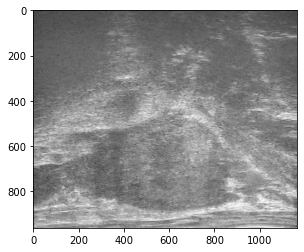

In [16]:
# reading png image file
img = mpimg.imread(test_img)
  
# show image
plt.imshow(img, cmap='gray')

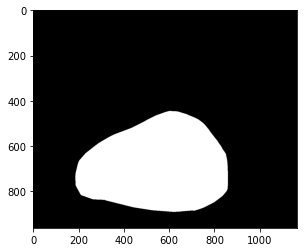

In [17]:
# reading png image file
mask = mpimg.imread(test_mask)
  
# show mask
plt.imshow(mask, cmap='gray')